# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [1]:
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import precision_recall_curve, average_precision_score

### Setting Data Path

In [ ]:
data_path = ...

### Functions to read files created by 2_modeltraining.py and to plot results

In [12]:
def pretty_results(filenames, filepath='../results/models/'):
    reslist = []
    for index1, filename in enumerate(filenames):
        res = pd.read_pickle(filepath+filename+'.pkl')
        for index2, cr in enumerate(res):
            trainval = ['train', 'val'][index2 % 2]
            sex = ['M', 'M', 'F', 'F'][index2 % 4]
            reslist.append([index1+1, trainval, sex, cr['1']['precision'], cr['1']['recall'], cr['1']['support'],
                            cr['0']['precision'], cr['0']['recall'], cr['0']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'trainval', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return(res)
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return(res_df)
 
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'trainval'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'val' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')

    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')

    if save:
        path = '../results/plots_performance/'
        plt.savefig(f'{path}{save}.png')

    plt.show()
    
def plot_precision_recall_comp(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.loc[res_df['trainval'] == 'val'].groupby(['sex', 'split'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'time' else 0.2
        hatch = '/' if name[1] == 'time' else ''
        colr = 'deepskyblue' if name[1] == 'time' else 'rebeccapurple'
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', 
                  hatch=hatch, color=colr)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['time', 'random'], bbox_to_anchor=legbox, loc=legloc, title='Train/test \nsplit')
    ax[1].legend(labels=['time', 'random'], bbox_to_anchor=legbox, loc=legloc, title='Train/test \nsplit')

    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()

    if save:
        path = '../results/plots_performance/'
        plt.savefig(f'{path}{save}.png')

    plt.show()

# Model performance of SVM using all predictor variables
## Precision and recall plots for both outcome classes
Note the zoomed-in y-axes for precision plots in order to see differences between models more clearly.

In [3]:
res_df = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models/')
res_df = get_scores(res_df)

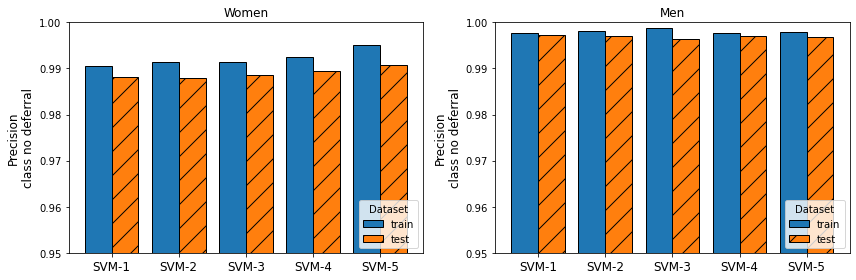

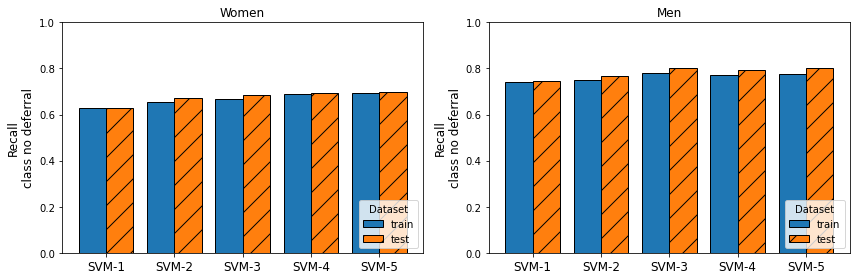

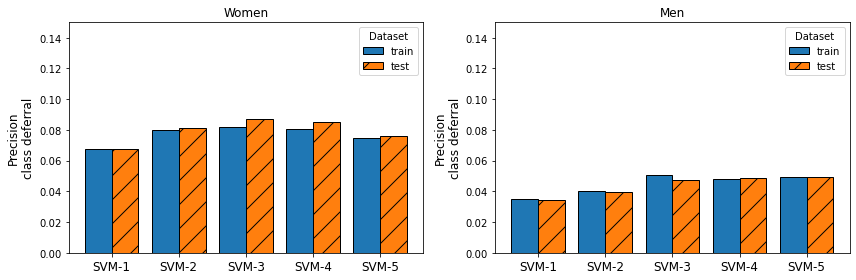

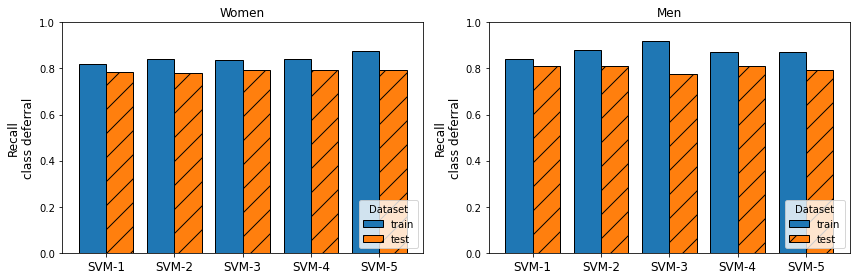

In [4]:
plot_precision_recall(res_df, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='all_ok_precision')
plot_precision_recall(res_df, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='all_ok_recall')
plot_precision_recall(res_df, 'low_precision', (0, 0.15), 'Precision\nclass deferral', 'all_low_precision')
plot_precision_recall(res_df, 'low_recall', (0, 1), 'Recall\nclass deferral', save='all_low_recall')

## Precision-recall curve
The PR curve shows the precision and recall at different probability thresholds for classification. This is more informative than a ROC curve because of the imbalanced outcome classes. A perfect classifier would have a precision of 1 for every recall value, so would look like a horizontal line at y=1. The area under the PR curve (AUPR) is a performance metric between 0 and 1 that indicates the quality of the classifier.  

### Functions to load probabilities and plot PR curves

In [16]:
def load_probas(sexes=('men', 'women'), path='../results/probas/proba_', nbacks = range(1, 6)):
    dfs = []
    for sex, nback in product(sexes, nbacks):
        df = pd.read_pickle(f'{path}{sex}_{nback}.pkl')
        df['sex'] = sex
        df['nback'] = nback
        dfs.append(df)
    return pd.concat(dfs)

def plot_prs(probas, save=False):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    for x, sex in enumerate(['men', 'women']):
        df = probas.loc[probas['sex'] == sex, ]

        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.HbOK, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.HbOK, group.prob_ok, pos_label=1)

            aupr_0 = round(average_precision_score(group.HbOK, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.HbOK, group.prob_ok, pos_label=1), 3)

            ax[0, x].plot(recall_0, precision_0, label=f'SVM-{key}, AUPR: {aupr_0}')
            ax[1, x].plot(recall_1, precision_1, label=f'SVM-{key}, AUPR: {aupr_1}')

        ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.5)

    #horizontal lines for baseline
    ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')

    if save:
        path = '../results/plots_performance/'
        plt.savefig(f'{path}{save}.png')

    plt.show()

First, predictions are made on the test set again, now storing the probability of each observation belonging to each outcome class. We also calculate the proportion of observations belonging to each class (true outcome), as these are the baseline values for the AUPR (the AUPR obtained by a classifier predicting only the majority class).

In [ ]:
for nback in range(1,6):
    file_clf = f'../results/models/clf_{nback}.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle(f'{data_path}scaled/{sex}_{nback}_test.pkl')
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = f'../results/probas/proba_{sex}_{nback}.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))
        
proba_m = pd.read_pickle('../results/probas/proba_men_1.pkl')
proba_f = pd.read_pickle('../results/probas/proba_women_1.pkl')
def_m = 1-np.mean(proba_m.HbOK)
def_f = 1-np.mean(proba_f.HbOK)

### PR curve 
PR curves for men and women, shown for each of the 5 SVMs. AUPR values are given in the legend. The grey dashed line indicates the baseline.

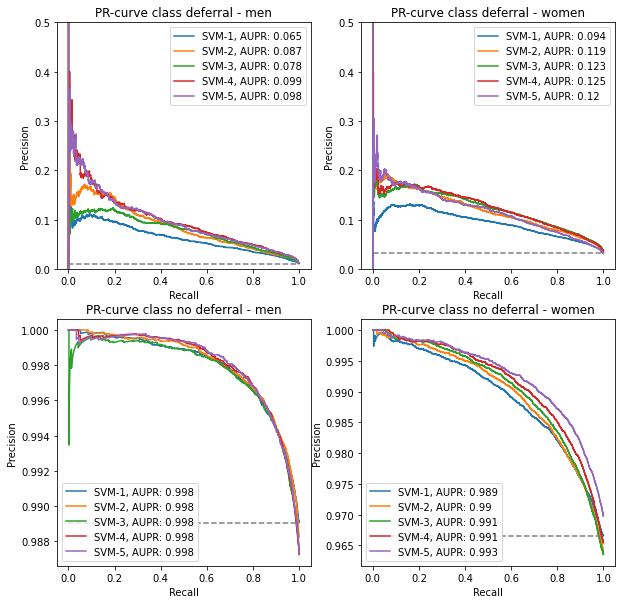

In [17]:
probas = load_probas()
plot_prs(probas, save='PR_curve')

## Actual and predicted deferral rates
There is a difference in deferral rate in the train and test (here 'val') sets. We calculate the difference in true deferral rate between the two sets, and the difference in predicted deferral rate by the model. We investigate the difference of these differences (column 'diffdiff') to see if the model captures these differences.

In [40]:
# Calculate predicted deferral rate per model
res_df['pred_def_n'] = res_df['ok_support'] - (res_df['ok_precision'] * res_df['ok_support']) + res_df['low_recall'] * res_df['low_support']
res_df['pred_defrate'] = res_df['pred_def_n'] / (res_df['ok_support'] + res_df['low_support'])
df_defrates = res_df[['nback', 'trainval', 'sex', 'old_defrate', 'pred_defrate']].copy()

defs = df_defrates.pivot(index=['nback', 'sex'], columns='trainval', values=['old_defrate', 'pred_defrate']).copy()
defs['old_defrate', 'diff'] = defs['old_defrate', 'val'] - defs['old_defrate', 'train']
defs['pred_defrate', 'diff'] = defs['pred_defrate', 'val'] - defs['pred_defrate', 'train']
defs['diffdiff'] = defs['pred_defrate', 'diff'] - defs['old_defrate', 'diff']
defs

old_defrate           pred_defrate           old_defrate  \
trainval        train       val        train       val        diff   
nback sex                                                            
1     F      0.031894  0.033409     0.035257  0.037579    0.001515   
      M      0.011011  0.010963     0.011614  0.011663   -0.000049   
2     F      0.034555  0.035947     0.037386  0.039675    0.001391   
      M      0.011775  0.011757     0.012246  0.012428   -0.000018   
3     F      0.034130  0.036479     0.036826  0.039836    0.002350   
      M      0.012563  0.012462     0.012841  0.013138   -0.000100   
4     F      0.031635  0.034597     0.033873  0.037662    0.002962   
      M      0.013168  0.012761     0.013665  0.013376   -0.000407   
5     F      0.027218  0.030275     0.028652  0.032905    0.003057   
      M      0.013040  0.012602     0.013513  0.013225   -0.000438   

          pred_defrate  diffdiff  
trainval          diff            
nback sex                         
1     F       0.002322  0.000807  
      M       0.000049  0.000098  
2     F       0.002290  0.000898  
      M       0.000181  0.000199  
3     F       0.003010  0.000660  
      M       0.000297  0.000397  
4     F       0.003789  0.000827  
      M      -0.000289  0.000118  
5     F       0.004253  0.001196  
      M      -0.000288  0.000150

In [45]:
print('The mean difference of the differences is {} percentage points, the maximum is {}.'.format(round(np.mean(defs['diffdiff']) * 100, 3),
                                                                                                  round(np.max(defs['diffdiff']) * 100, 3)))

The mean difference of the differences is 0.053 percentage points, the maximum is 0.12.


### Performance comparison with random train/test split

In [8]:
res_df_randomsplit = pretty_results(['res_1', 'res_2', 'res_3', 'res_4', 'res_5'], filepath='../results/models_randomsplit/')
res_df_randomsplit = get_scores(res_df_randomsplit)

In [9]:
res_df['split'] = 'time'
res_df_randomsplit['split'] = 'random'

res_tot = pd.concat([res_df, res_df_randomsplit])
res_tot.head()

,nback,trainval,sex,ok_precision,ok_recall,ok_support,low_precision,low_recall,low_support,old_defrate,new_defrate,missed_dons,prevented_defs,missed_per_prev,old_def_n,new_def_n,old_don_n,new_don_n,split
0,1,train,M,0.997628,0.741436,120264,0.034975,0.841673,1339,0.011011,0.002372,0.258564,0.841673,29.509947,1339,285.0,120264,89168.0,time
1,1,val,M,0.997173,0.747547,96715,0.034292,0.808769,1072,0.010963,0.002827,0.252453,0.808769,30.575606,1072,273.0,96715,72299.0,time
2,1,train,F,0.990522,0.627414,123754,0.067431,0.817758,4077,0.031894,0.009478,0.372586,0.817758,15.877762,4077,1173.0,123754,77645.0,time
3,1,val,F,0.988179,0.627488,105516,0.067717,0.782835,3647,0.033409,0.011821,0.372512,0.782835,16.379250,3647,1247.0,105516,66210.0,time
4,2,train,M,0.998071,0.751060,95091,0.040337,0.878199,1133,0.011775,0.001929,0.248940,0.878199,24.928026,1133,183.0,95091,71419.0,time


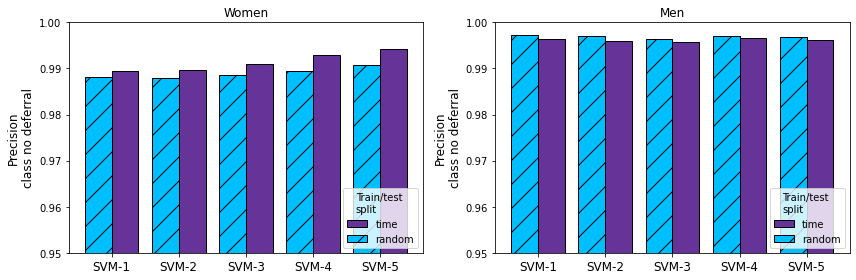

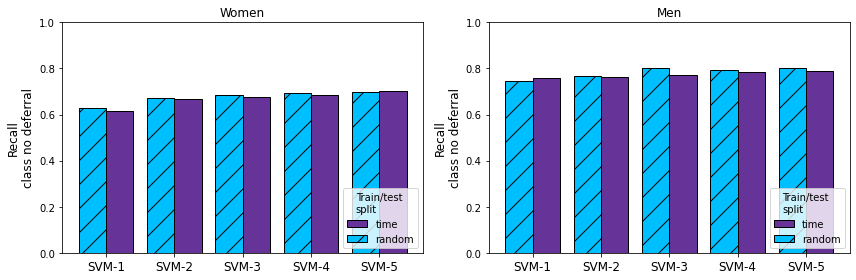

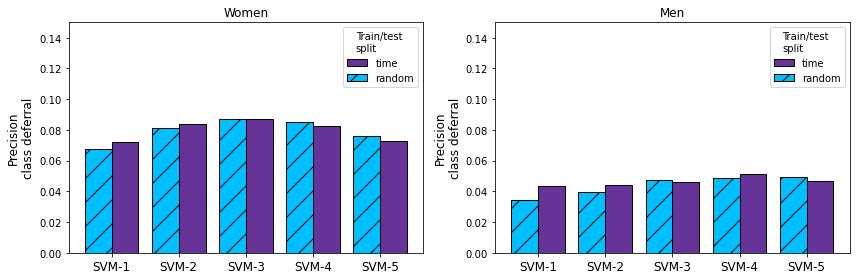

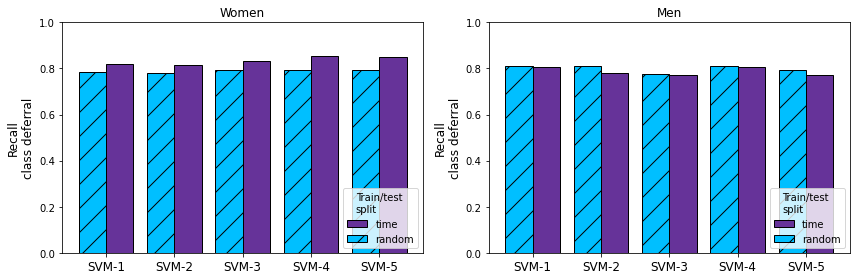

In [18]:
plot_precision_recall_comp(res_tot, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='comparesplits_ok_precision')
plot_precision_recall_comp(res_tot, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='comparesplits_ok_recall')
plot_precision_recall_comp(res_tot, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='comparesplits_low_precision')
plot_precision_recall_comp(res_tot, 'low_recall', (0, 1), 'Recall\nclass deferral', save='comparesplits_low_recall')

### Numerical comparison of performance for time/random split

In [14]:
comp_res = res_tot.loc[res_tot['trainval'] == 'val', 
                       ['nback', 'sex', 
                        'ok_precision', 'ok_recall',
                        'low_precision', 'low_recall', 
                        'split']].pivot(index=['nback', 'sex'], columns='split')

comp_res['ok_precision', 'diff'] = comp_res['ok_precision', 'time'] - comp_res['ok_precision', 'random']
comp_res['ok_recall', 'diff'] = comp_res['ok_recall', 'time'] - comp_res['ok_recall', 'random']
comp_res['low_precision', 'diff'] = comp_res['low_precision', 'time'] - comp_res['low_precision', 'random']
comp_res['low_recall', 'diff'] = comp_res['low_precision', 'time'] - comp_res['low_precision', 'random']

comp_res

ok_precision           ok_recall           low_precision            \
split           random      time    random      time        random      time   
nback sex                                                                      
1     F       0.989437  0.988179  0.613285  0.627488      0.071854  0.067717   
      M       0.996499  0.997173  0.756775  0.747547      0.043185  0.034292   
2     F       0.989598  0.987979  0.666344  0.670104      0.083691  0.081146   
      M       0.995965  0.997056  0.764335  0.767124      0.044175  0.039714   
3     F       0.990875  0.988662  0.678247  0.684857      0.086957  0.086937   
      M       0.995761  0.996505  0.772940  0.801473      0.046252  0.047083   
4     F       0.992981  0.989348  0.683867  0.694440      0.082427  0.084931   
      M       0.996525  0.996941  0.786632  0.794161      0.051348  0.048489   
5     F       0.994126  0.990807  0.701443  0.698486      0.072792  0.075830   
      M       0.996146  0.996739  0.790567  0.803946      0.046886  0.049142   

          low_recall           ok_precision ok_recall low_precision low_recall  
split         random      time         diff      diff          diff       diff  
nback sex                                                                       
1     F     0.820550  0.782835    -0.001257  0.014203     -0.004137  -0.004137  
      M     0.805031  0.808769     0.000673 -0.009228     -0.008893  -0.008893  
2     F     0.813121  0.781343    -0.001619  0.003760     -0.002545  -0.002545  
      M     0.778626  0.809572     0.001091  0.002788     -0.004461  -0.004461  
3     F     0.830688  0.792547    -0.002214  0.006610     -0.000020  -0.000020  
      M     0.769912  0.777283     0.000745  0.028533      0.000831   0.000831  
4     F     0.854545  0.791371    -0.003633  0.010572      0.002503   0.002503  
      M     0.808081  0.811486     0.000416  0.007529     -0.002859  -0.002859  
5     F     0.849741  0.792424    -0.003319 -0.002957      0.003038   0.003038  
      M     0.771084  0.793904     0.000593  0.013379      0.002256   0.002256